In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

In [ ]:
# --- 1. Load Data ---
try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
except FileNotFoundError:
    print("Error: file not found.")
    exit()

print("--- Initial Data Head ---")
print(df.head())
print("\n--- Data Info ---")
df.info()

--- Initial Data Head ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingM

In [ ]:
# --- 2. Data Cleaning and Preprocessing ---

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.drop('customerID', axis=1)
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)

target = 'Churn'
df[target] = df[target].map({'Yes': 1, 'No': 0})

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove(target)

print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")


Categorical features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical features: ['tenure', 'MonthlyCharges', 'TotalCharges']


<ipython-input-20-af82cff5c56c>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [ ]:
# --- 3. Prepare Data for Modeling ---
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# --- 4. Model Training and Evaluation ---

def evaluate_model(name, model, X_test_processed, y_test):
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n--- {name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Store metrics for later comparison table
    metrics = {
        'Accuracy': accuracy, 'Precision': precision,
        'Recall': recall, 'F1-Score': f1, 'ROC AUC': roc_auc
    }
    return metrics, cm, y_proba
#class imbalance variable(mention in slides)
scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()

# --- Model 1: Logistic Regression ---
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(solver='liblinear',
                                                                class_weight='balanced',
                                                                random_state=42))])
lr_pipeline.fit(X_train, y_train)
lr_metrics, lr_cm, lr_proba = evaluate_model("Logistic Regression", lr_pipeline, X_test, y_test)

# --- Model 2: Gradient Boosting (XGBoost) ---
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(random_state=42,
                                                            use_label_encoder=False,
                                                            eval_metric='logloss',
                                                            scale_pos_weight=scale_pos_weight_value))])
xgb_pipeline.fit(X_train, y_train)
xgb_metrics, xgb_cm, xgb_proba = evaluate_model("XGBoost", xgb_pipeline, X_test, y_test)



--- Logistic Regression Performance ---
Accuracy: 0.7381
Precision: 0.5043
Recall: 0.7834
F1-Score: 0.6136
ROC AUC: 0.8417
Confusion Matrix:
[[747 288]
 [ 81 293]]

--- XGBoost Performance ---
Accuracy: 0.7594
Precision: 0.5361
Recall: 0.6952
F1-Score: 0.6054
ROC AUC: 0.8316
Confusion Matrix:
[[810 225]
 [114 260]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:49:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


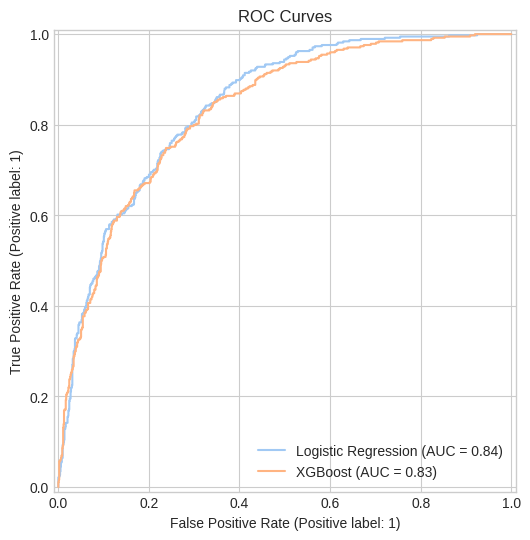

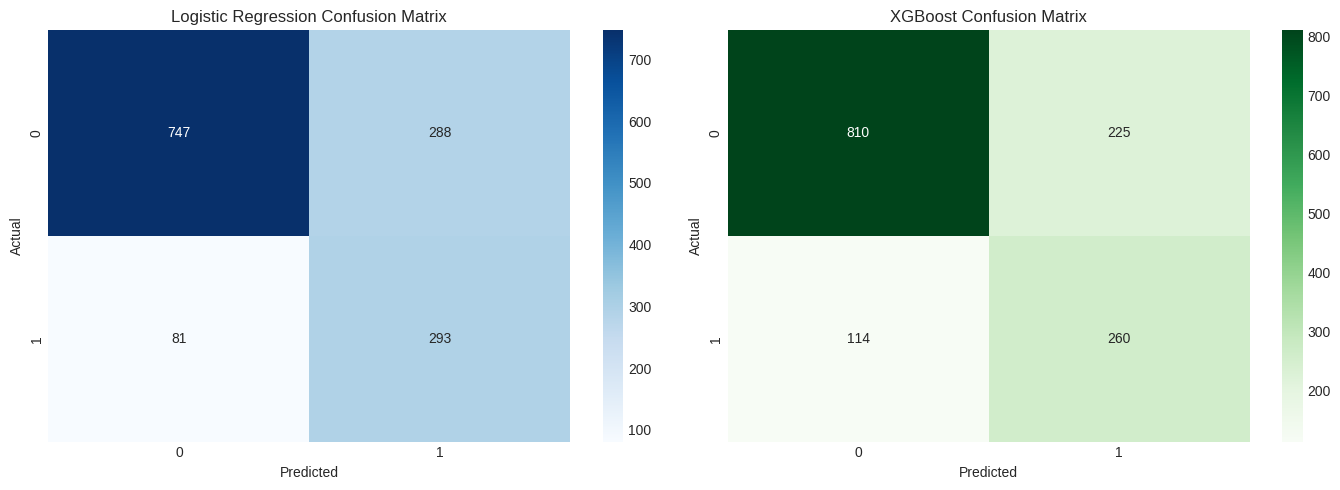

In [ ]:
# --- 5. Results Visualization ---

# ROC Curves
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(lr_pipeline, X_test, y_test, name='Logistic Regression', ax=plt.gca())
RocCurveDisplay.from_estimator(xgb_pipeline, X_test, y_test, name='XGBoost', ax=plt.gca())
plt.title('ROC Curves')
plt.savefig('roc_curves.png')
plt.show()

# Confusion Matrices Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('XGBoost Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()


--- Logistic Regression Coefficients ---
                                     Coefficient
cat__Contract_Two year                 -1.418777
num__tenure                            -1.143264
cat__InternetService_Fiber optic        1.117978
cat__Contract_One year                 -0.721328
num__TotalCharges                       0.474908
num__MonthlyCharges                    -0.421108
cat__PhoneService_Yes                  -0.400274
cat__PaymentMethod_Electronic check     0.397358
cat__StreamingMovies_Yes                0.381526
cat__OnlineSecurity_Yes                -0.355790


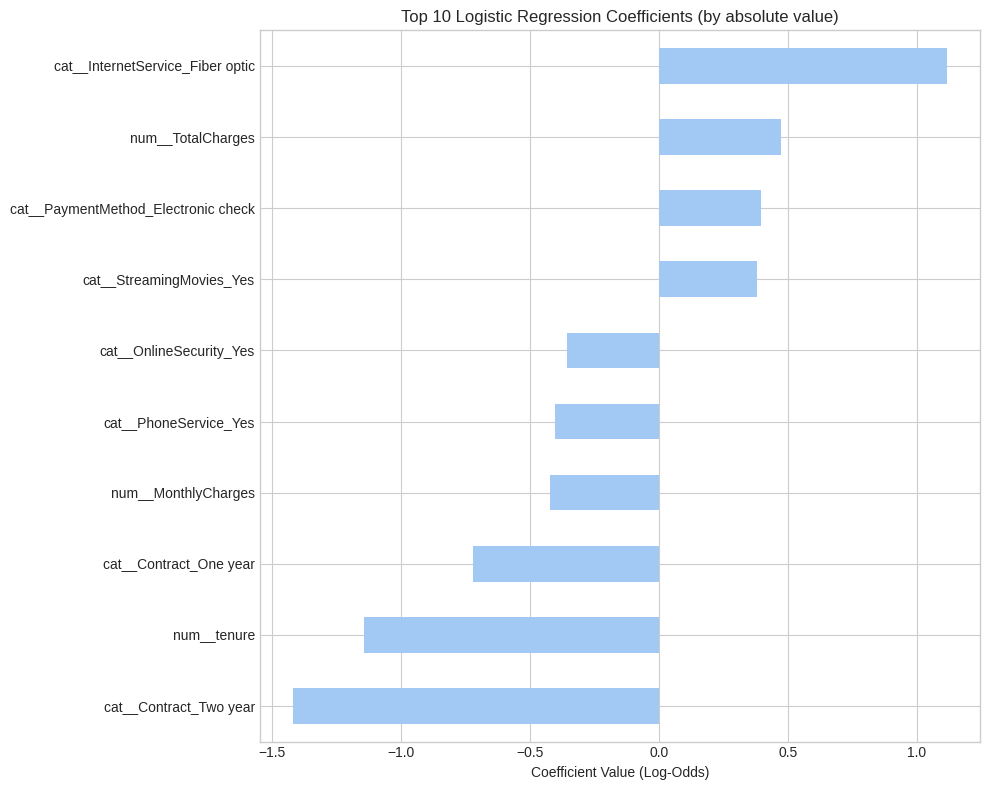


--- XGBoost Feature Importances ---
                                Feature  Importance
25               cat__Contract_Two year    0.322349
10     cat__InternetService_Fiber optic    0.216179
24               cat__Contract_One year    0.132932
11              cat__InternetService_No    0.068192
23             cat__StreamingMovies_Yes    0.040171
0                           num__tenure    0.018058
7                 cat__PhoneService_Yes    0.017948
28  cat__PaymentMethod_Electronic check    0.016220
9                cat__MultipleLines_Yes    0.014488
26            cat__PaperlessBilling_Yes    0.013506


<ipython-input-24-0cf7f8820038>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=xgb_features_df.head(10), palette="viridis")


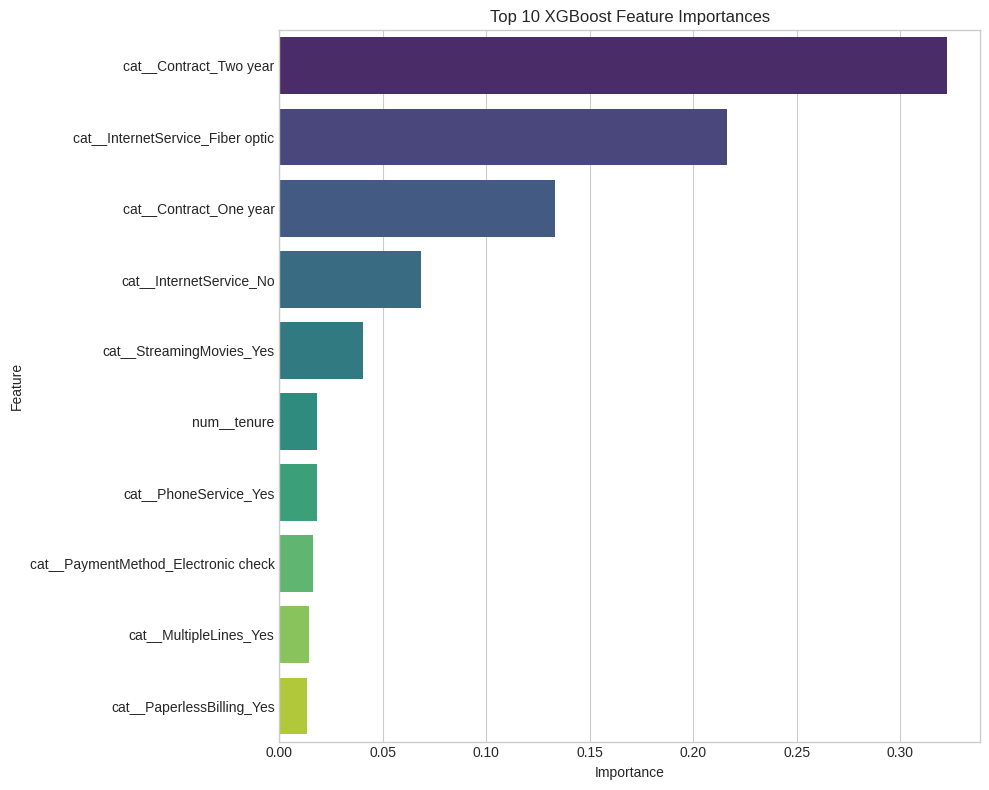


--- Model Performance Summary ---
                     Accuracy  Precision    Recall  F1-Score   ROC AUC
Logistic Regression  0.738112   0.504303  0.783422  0.613613  0.841745
XGBoost              0.759404   0.536082  0.695187  0.605355  0.831568


In [ ]:
# --- 6. Feature Importances ---

feature_names_out = lr_pipeline.named_steps['preprocessor'].get_feature_names_out()
lr_coefs = pd.DataFrame(
    lr_pipeline.named_steps['classifier'].coef_[0],
    index=feature_names_out,
    columns=['Coefficient']
).sort_values(by='Coefficient', key=abs, ascending=False)

print("\n--- Logistic Regression Coefficients ---")
print(lr_coefs.head(10))

plt.figure(figsize=(10, 8))
lr_coefs_top_10 = lr_coefs.head(10).sort_values(by='Coefficient', ascending=True)
lr_coefs_top_10['Coefficient'].plot(kind='barh')
plt.title('Top 10 Logistic Regression Coefficients (by absolute value)')
plt.xlabel('Coefficient Value (Log-Odds)')
plt.tight_layout()
plt.savefig('lr_coefficients.png')
plt.show()

xgb_importances = xgb_pipeline.named_steps['classifier'].feature_importances_
xgb_features_df = pd.DataFrame({
    'Feature': feature_names_out,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

print("\n--- XGBoost Feature Importances ---")
print(xgb_features_df.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=xgb_features_df.head(10), palette="viridis")
plt.title('Top 10 XGBoost Feature Importances')
plt.tight_layout()
plt.savefig('xgb_feature_importances.png')
plt.show()

# --- Summary Table for Presentation ---
summary_df = pd.DataFrame({
    'Logistic Regression': lr_metrics,
    'XGBoost': xgb_metrics
}).T
print("\n--- Model Performance Summary ---")
print(summary_df)
summary_df.to_csv('model_performance_summary.csv')

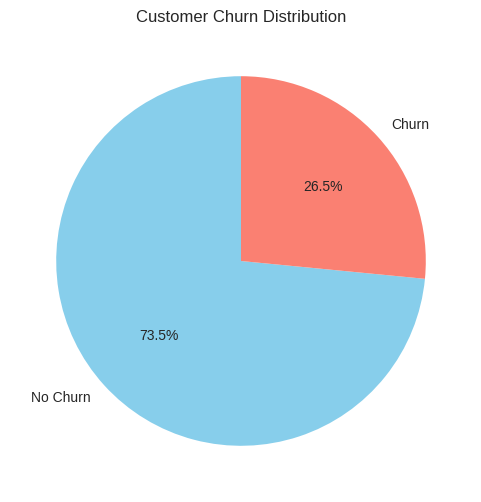

Churn
0    5174
1    1869
Name: count, dtype: int64
Churn Percentage: 26.54%


In [ ]:
temp_churn_series = df['Churn']

churn_counts = temp_churn_series.value_counts()
churn_labels = ['No Churn', 'Churn']

plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=churn_labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Customer Churn Distribution')
plt.savefig('churn_distribution_pie.png')
plt.show()

print(churn_counts)
print(f"Churn Percentage: {churn_counts[1] / len(df) * 100:.2f}%")